## Importing Packages

In [20]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
import scipy.stats as stats
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from graphviz import Source
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from mlxtend.classifier import StackingClassifier

from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

## Importing Data

Data found at https://archive.ics.uci.edu/ml/datasets/wine+quality
On page https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

In [21]:
red = pd.read_csv('data/winequality-red.csv',delimiter=';')
white = pd.read_csv('data/winequality-white.csv',delimiter=';')
red['type'] = 'red'
white['type'] = 'white'
wines = pd.concat([red,white])

In [22]:
wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

In [23]:
wines.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            6.8              0.56         0.22             1.8      0.074   
1            6.4              0.30         0.36             2.0      0.052   
2            5.9              0.17         0.29             3.1      0.030   
3            7.0              0.24         0.24             1.8      0.047   
4            6.4              0.45         0.07             1.1      0.030   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 15.0                  24.0  0.99438  3.40       0.82   
1                 18.0                 141.0  0.99273  3.38       0.53   
2                 32.0                 123.0  0.98913  3.41       0.33   
3                 29.0                  91.0  0.99251  3.30       0.43   
4                 10.0                 131.0  0.99050  2.97       0.28   

   alcohol  quality   type quality_label  
0     11.2        6    red        medium  
1     10.5        6  white        medium  
2     13.7        7  white        medium  
3      9.9        6  white        medium  
4     10.8        5  white           low

## Exploratory Data Analysis (EDA)

In [24]:
len(wines)

6497

In [25]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
 13  quality_label         6497 non-null   object 
dtypes: float64(11), int64(1), object(2)
memory usage: 710.7+ KB


In [26]:
vals = sorted(wines.quality.unique())
vals

[3, 4, 5, 6, 7, 8, 9]

In [27]:
### PLOT THESE
skewness = wines.skew()
kurtosis = wines.kurtosis()
corr = wines.corr()

In [28]:
wines.quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [29]:
for i in wines.columns:
    print(f'{i.title()}:  {sum(wines[i].isnull())} nulls')

Fixed Acidity:  0 nulls
Volatile Acidity:  0 nulls
Citric Acid:  0 nulls
Residual Sugar:  0 nulls
Chlorides:  0 nulls
Free Sulfur Dioxide:  0 nulls
Total Sulfur Dioxide:  0 nulls
Density:  0 nulls
Ph:  0 nulls
Sulphates:  0 nulls
Alcohol:  0 nulls
Quality:  0 nulls
Type:  0 nulls
Quality_Label:  0 nulls


In [30]:
wines.dropna().quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

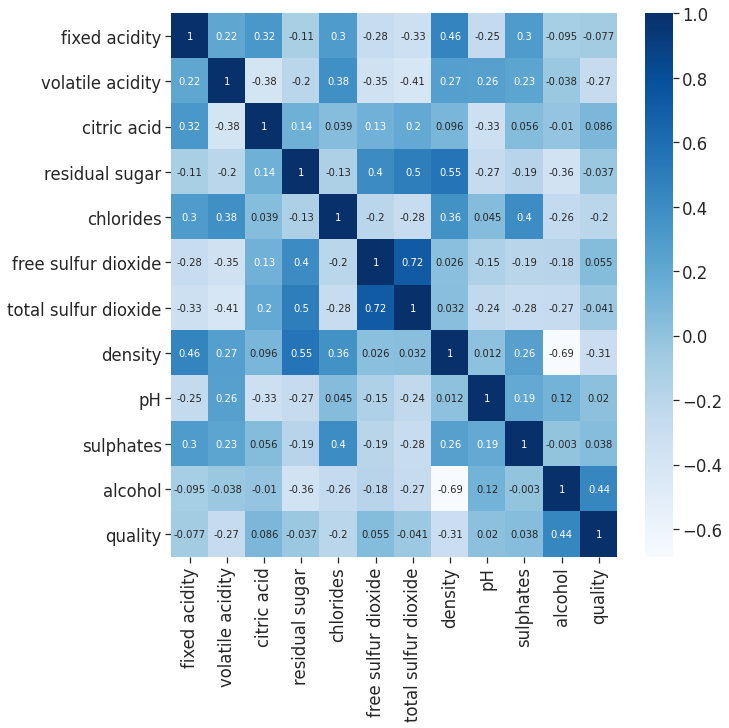

In [31]:
# Getting Corellations Between Each Feature
corrmat = wines.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(wines[top_corr_features].corr(),annot=True,cmap="Blues")

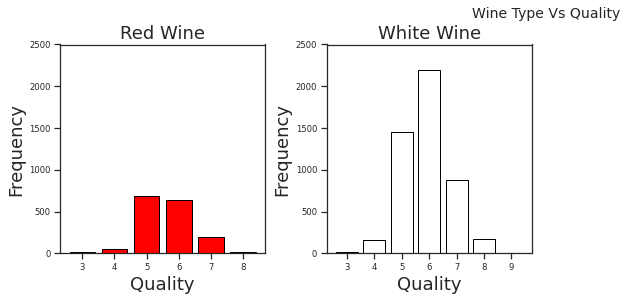

In [34]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
rw_q = wines.quality[wines.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1], color='red', edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,4, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = wines.quality[wines.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='white', edgecolor='black', linewidth=1) 

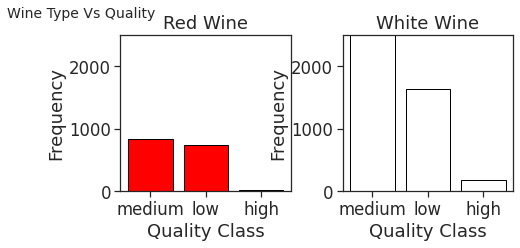

In [35]:
fig = plt.figure(figsize = (15, 3))
title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)


ax1 = fig.add_subplot(1,4, 3)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality Class")
ax1.set_ylabel("Frequency") 
rw_q = wines.quality_label[wines.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
bar1 = ax1.bar(list(range(len(rw_q[0]))), rw_q[1], color='red', edgecolor='black', linewidth=1, tick_label =rw_q[0])

ax2 = fig.add_subplot(1,4, 4)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality Class")
ax2.set_ylabel("Frequency") 
ww_q = wines.quality_label[wines.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
bar2 = ax2.bar(list(range(len(ww_q[0]))), ww_q[1], color='white', edgecolor='black', linewidth=1, tick_label =ww_q[0])

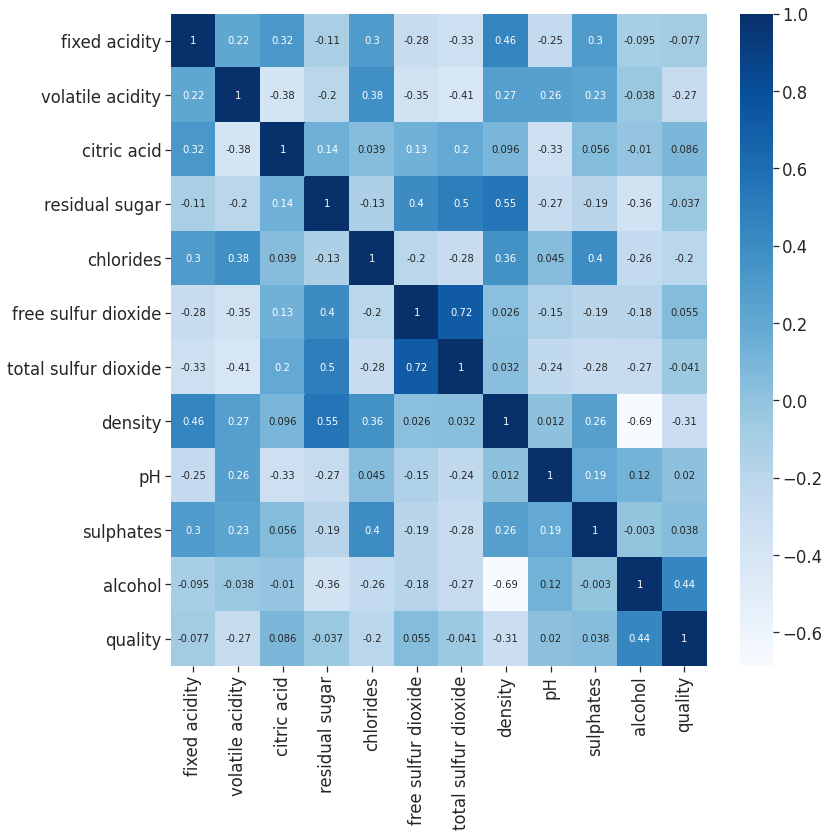

In [37]:
# Getting Corellations Between Each Feature
corrmat = wines.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12,12))
#plot heat map
g=sns.heatmap(wines[top_corr_features].corr(),annot=True,cmap="Blues")

In [38]:
class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values) # 1 - White; 0 - Red
wines['color'] = y_tp

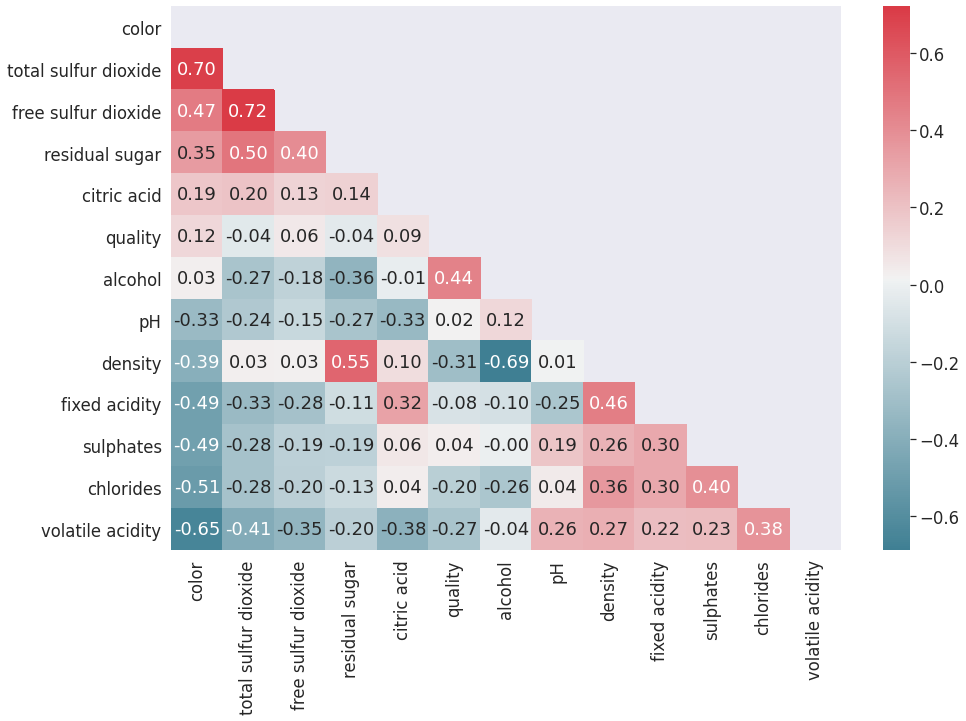

In [40]:
corr = wines.corr()
top_corr_cols = corr.color.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(15, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)
plt.show()
del corr, dropSelf, top_corr

### EDA: Descriptive Statistics

In [48]:
subset_attributes = wines.columns
rs = round(wines.loc[wines.type == 'red', subset_attributes].describe(),2)
ws = round(wines.loc[wines.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1599.0   8.32   1.74  4.60   7.10   7.90   
volatile acidity                  1599.0   0.53   0.18  0.12   0.39   0.52   
citric acid                       1599.0   0.27   0.19  0.00   0.09   0.26   
residual sugar                    1599.0   2.54   1.41  0.90   1.90   2.20   
chlorides                         1599.0   0.09   0.05  0.01   0.07   0.08   
free sulfur dioxide               1599.0  15.87  10.46  1.00   7.00  14.00   
total sulfur dioxide              1599.0  46.47  32.90  6.00  22.00  38.00   
density                           1599.0   1.00   0.00  0.99   1.00   1.00   
pH                                1599.0   3.31   0.15  2.74   3.21   3.31   
sulphates                         1599.0   0.66   0.17  0.33   0.55   0.62   
alcohol                           1599.0  10.42   1.07  8.40   9.50  10.20   
quality                           1599.0   5.64   0.81  3.00   5.00   6.00   
color                             1599.0   0.00   0.00  0.00   0.00   0.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.20   15.90                4898.0    6.85   0.84   
volatile acidity       0.64    1.58                4898.0    0.28   0.10   
citric acid            0.42    1.00                4898.0    0.33   0.12   
residual sugar         2.60   15.50                4898.0    6.39   5.07   
chlorides              0.09    0.61                4898.0    0.05   0.02   
free sulfur dioxide   21.00   72.00                4898.0   35.31  17.01   
total sulfur dioxide  62.00  289.00                4898.0  138.36  42.50   
density                1.00    1.00                4898.0    0.99   0.00   
pH                     3.40    4.01                4898.0    3.19   0.15   
sulphates              0.73    2.00                4898.0    0.49   0.11   
alcohol               11.10   14.90                4898.0   10.51   1.23   
quality                6.00    8.00                4898.0    5.88   0.89   
color                  0.00    0.00                4898.0    1.00   0.00   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.80    7.30   14.20  
volatile acidity      0.08    0.21    0.26    0.32    1.10  
citric acid           0.00    0.27    0.32    0.39    1.66  
residual sugar        0.60    1.70    5.20    9.90   65.80  
chlorides             0.01    0.04    0.04    0.05    0.35  
free sulfur dioxide   2.00   23.00   34.00   46.00  289.00  
total sulfur dioxide  9.00  108.00  134.00  167.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.09    3.18    3.28    3.82  
sulphates             0.22    0.41    0.47    0.55    1.08  
alcohol               8.00    9.50   10.40   11.40   14.20  
quality               3.00    5.00    6.00    6.00    9.00  
color                 1.00    1.00    1.00    1.00    1.00

In [49]:
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines[wines['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines[wines['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines[wines['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2384.0    7.33   1.27  4.20   6.50    7.10   
volatile acidity               2384.0    0.40   0.19  0.10   0.26    0.34   
citric acid                    2384.0    0.30   0.16  0.00   0.21    0.30   
residual sugar                 2384.0    5.65   4.92  0.60   1.80    2.90   
chlorides                      2384.0    0.06   0.04  0.01   0.04    0.05   
free sulfur dioxide            2384.0   29.48  19.84  2.00  14.00   26.00   
total sulfur dioxide           2384.0  119.28  61.89  6.00  68.00  124.00   
density                        2384.0    1.00   0.00  0.99   0.99    1.00   
pH                             2384.0    3.21   0.16  2.74   3.11    3.20   
sulphates                      2384.0    0.52   0.14  0.25   0.44    0.50   
alcohol                        2384.0    9.87   0.84  8.00   9.30    9.60   
quality                        2384.0    4.88   0.36  3.00   5.00    5.00   
color                          2384.0    0.69   0.46  0.00   0.00    1.00   

                                     Medium Quality Wine          ...          \
                         75%     max               count    mean  ...     75%   
fixed acidity           7.80   15.90              3915.0    7.16  ...    7.60   
volatile acidity        0.50    1.58              3915.0    0.31  ...    0.36   
citric acid             0.40    1.00              3915.0    0.33  ...    0.39   
residual sugar          8.52   23.50              3915.0    5.32  ...    7.90   
chlorides               0.08    0.61              3915.0    0.05  ...    0.06   
free sulfur dioxide    42.00  289.00              3915.0   30.96  ...   41.00   
total sulfur dioxide  167.00  440.00              3915.0  113.51  ...  150.00   
density                 1.00    1.00              3915.0    0.99  ...    1.00   
pH                      3.31    3.90              3915.0    3.22  ...    3.33   
sulphates               0.58    2.00              3915.0    0.54  ...    0.61   
alcohol                10.40   14.90              3915.0   10.81  ...   11.70   
quality                 5.00    5.00              3915.0    6.28  ...    7.00   
color                   1.00    1.00              3915.0    0.79  ...    1.00   

                             High Quality Wine                               \
                         max             count    mean    std    min    25%   
fixed acidity          15.60             198.0    6.85   1.14   3.90   6.20   
volatile acidity        1.04             198.0    0.29   0.12   0.12   0.21   
citric acid             1.66             198.0    0.33   0.10   0.03   0.28   
residual sugar         65.80             198.0    5.35   4.16   0.80   2.00   
chlorides               0.42             198.0    0.04   0.02   0.01   0.03   
free sulfur dioxide   112.00             198.0   34.51  17.08   3.00  24.00   
total sulfur dioxide  294.00             198.0  117.48  41.69  12.00  96.00   
density                 1.04             198.0    0.99   0.00   0.99   0.99   
pH                      4.01             198.0    3.23   0.16   2.88   3.13   
sulphates               1.95             198.0    0.51   0.16   0.25   0.38   
alcohol                14.20             198.0   11.69   1.27   8.50  11.00   
quality                 7.00             198.0    8.03   0.16   8.00   8.00   
color                   1.00             198.0    0.91   0.29   0.00   1.00   

                                              
                         50%     75%     max  
fixed acidity           6.80    7.30   12.60  
volatile acidity        0.28    0.35    0.85  
citric acid             0.32    0.37    0.74  
residual sugar          4.05    7.57   14.80  
chlorides               0.04    0.04    0.12  
free sulfur dioxide    34.00   43.00  105.00  
total sulfur dioxide  118.50  145.00  212.50  
density                 0.99    0.99    

In [50]:
def type_inf_stat_test(feature):
    F, p = f_oneway(wines[wines.type == 'red'][feature], 
                    wines[wines.type == 'white'][feature])
    if p <= 0.05:
        msg = 'Reject'
    else:
        msg = 'Acept'
    print(f'F Statistic: {round(F,2)} \tp-value: {round(p,2)} \tNull Hypothesis: {msg}')
    print('')
    
def quality_inf_stat_test(feature):
    F, p = f_oneway(wines[wines.quality_label == 'low'][feature], 
                    wines[wines.quality_label == 'medium'][feature], 
                    wines[wines.quality_label == 'high'][feature])
    if p <= 0.05:
        msg = 'Reject'
    else:
        msg = 'Accept'
    print(f'F Statistic: {round(F,2)} \tp-value: {round(p,2)} \tNull Hypothesis: {msg}')
    print('')

In [51]:
print('ANOVA test across wine samples with different types:\n')
features_1 = ['residual sugar', 'total sulfur dioxide',  'sulphates', 'fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'pH']
for i in features_1:
    print(f'* {i.title()}')
    type_inf_stat_test(i)

ANOVA test across wine samples with different types:

* Residual Sugar
F Statistic: 899.77 	p-value: 0.0 	Null Hypothesis: Reject

* Total Sulfur Dioxide
F Statistic: 6252.8 	p-value: 0.0 	Null Hypothesis: Reject

* Sulphates
F Statistic: 2021.71 	p-value: 0.0 	Null Hypothesis: Reject

* Fixed Acidity
F Statistic: 2016.51 	p-value: 0.0 	Null Hypothesis: Reject

* Volatile Acidity
F Statistic: 4829.32 	p-value: 0.0 	Null Hypothesis: Reject

* Citric Acid
F Statistic: 236.39 	p-value: 0.0 	Null Hypothesis: Reject

* Chlorides
F Statistic: 2315.83 	p-value: 0.0 	Null Hypothesis: Reject

* Ph
F Statistic: 789.05 	p-value: 0.0 	Null Hypothesis: Reject



In [52]:
print('ANOVA test across wine samples with different levels of quality:\n')
features_2 = ['alcohol', 'chlorides', 'volatile acidity', 'free sulfur dioxide', 'fixed acidity']
for i in features_2:
    print(f'* {i.title()}')
    quality_inf_stat_test(i)

ANOVA test across wine samples with different levels of quality:

* Alcohol
F Statistic: 673.07 	p-value: 0.0 	Null Hypothesis: Reject

* Chlorides
F Statistic: 120.96 	p-value: 0.0 	Null Hypothesis: Reject

* Volatile Acidity
F Statistic: 250.34 	p-value: 0.0 	Null Hypothesis: Reject

* Free Sulfur Dioxide
F Statistic: 10.31 	p-value: 0.0 	Null Hypothesis: Reject

* Fixed Acidity
F Statistic: 20.38 	p-value: 0.0 	Null Hypothesis: Reject



In [53]:
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values) # 1 - White; 0 - Red
wines['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines.quality_label.map(class_ql)

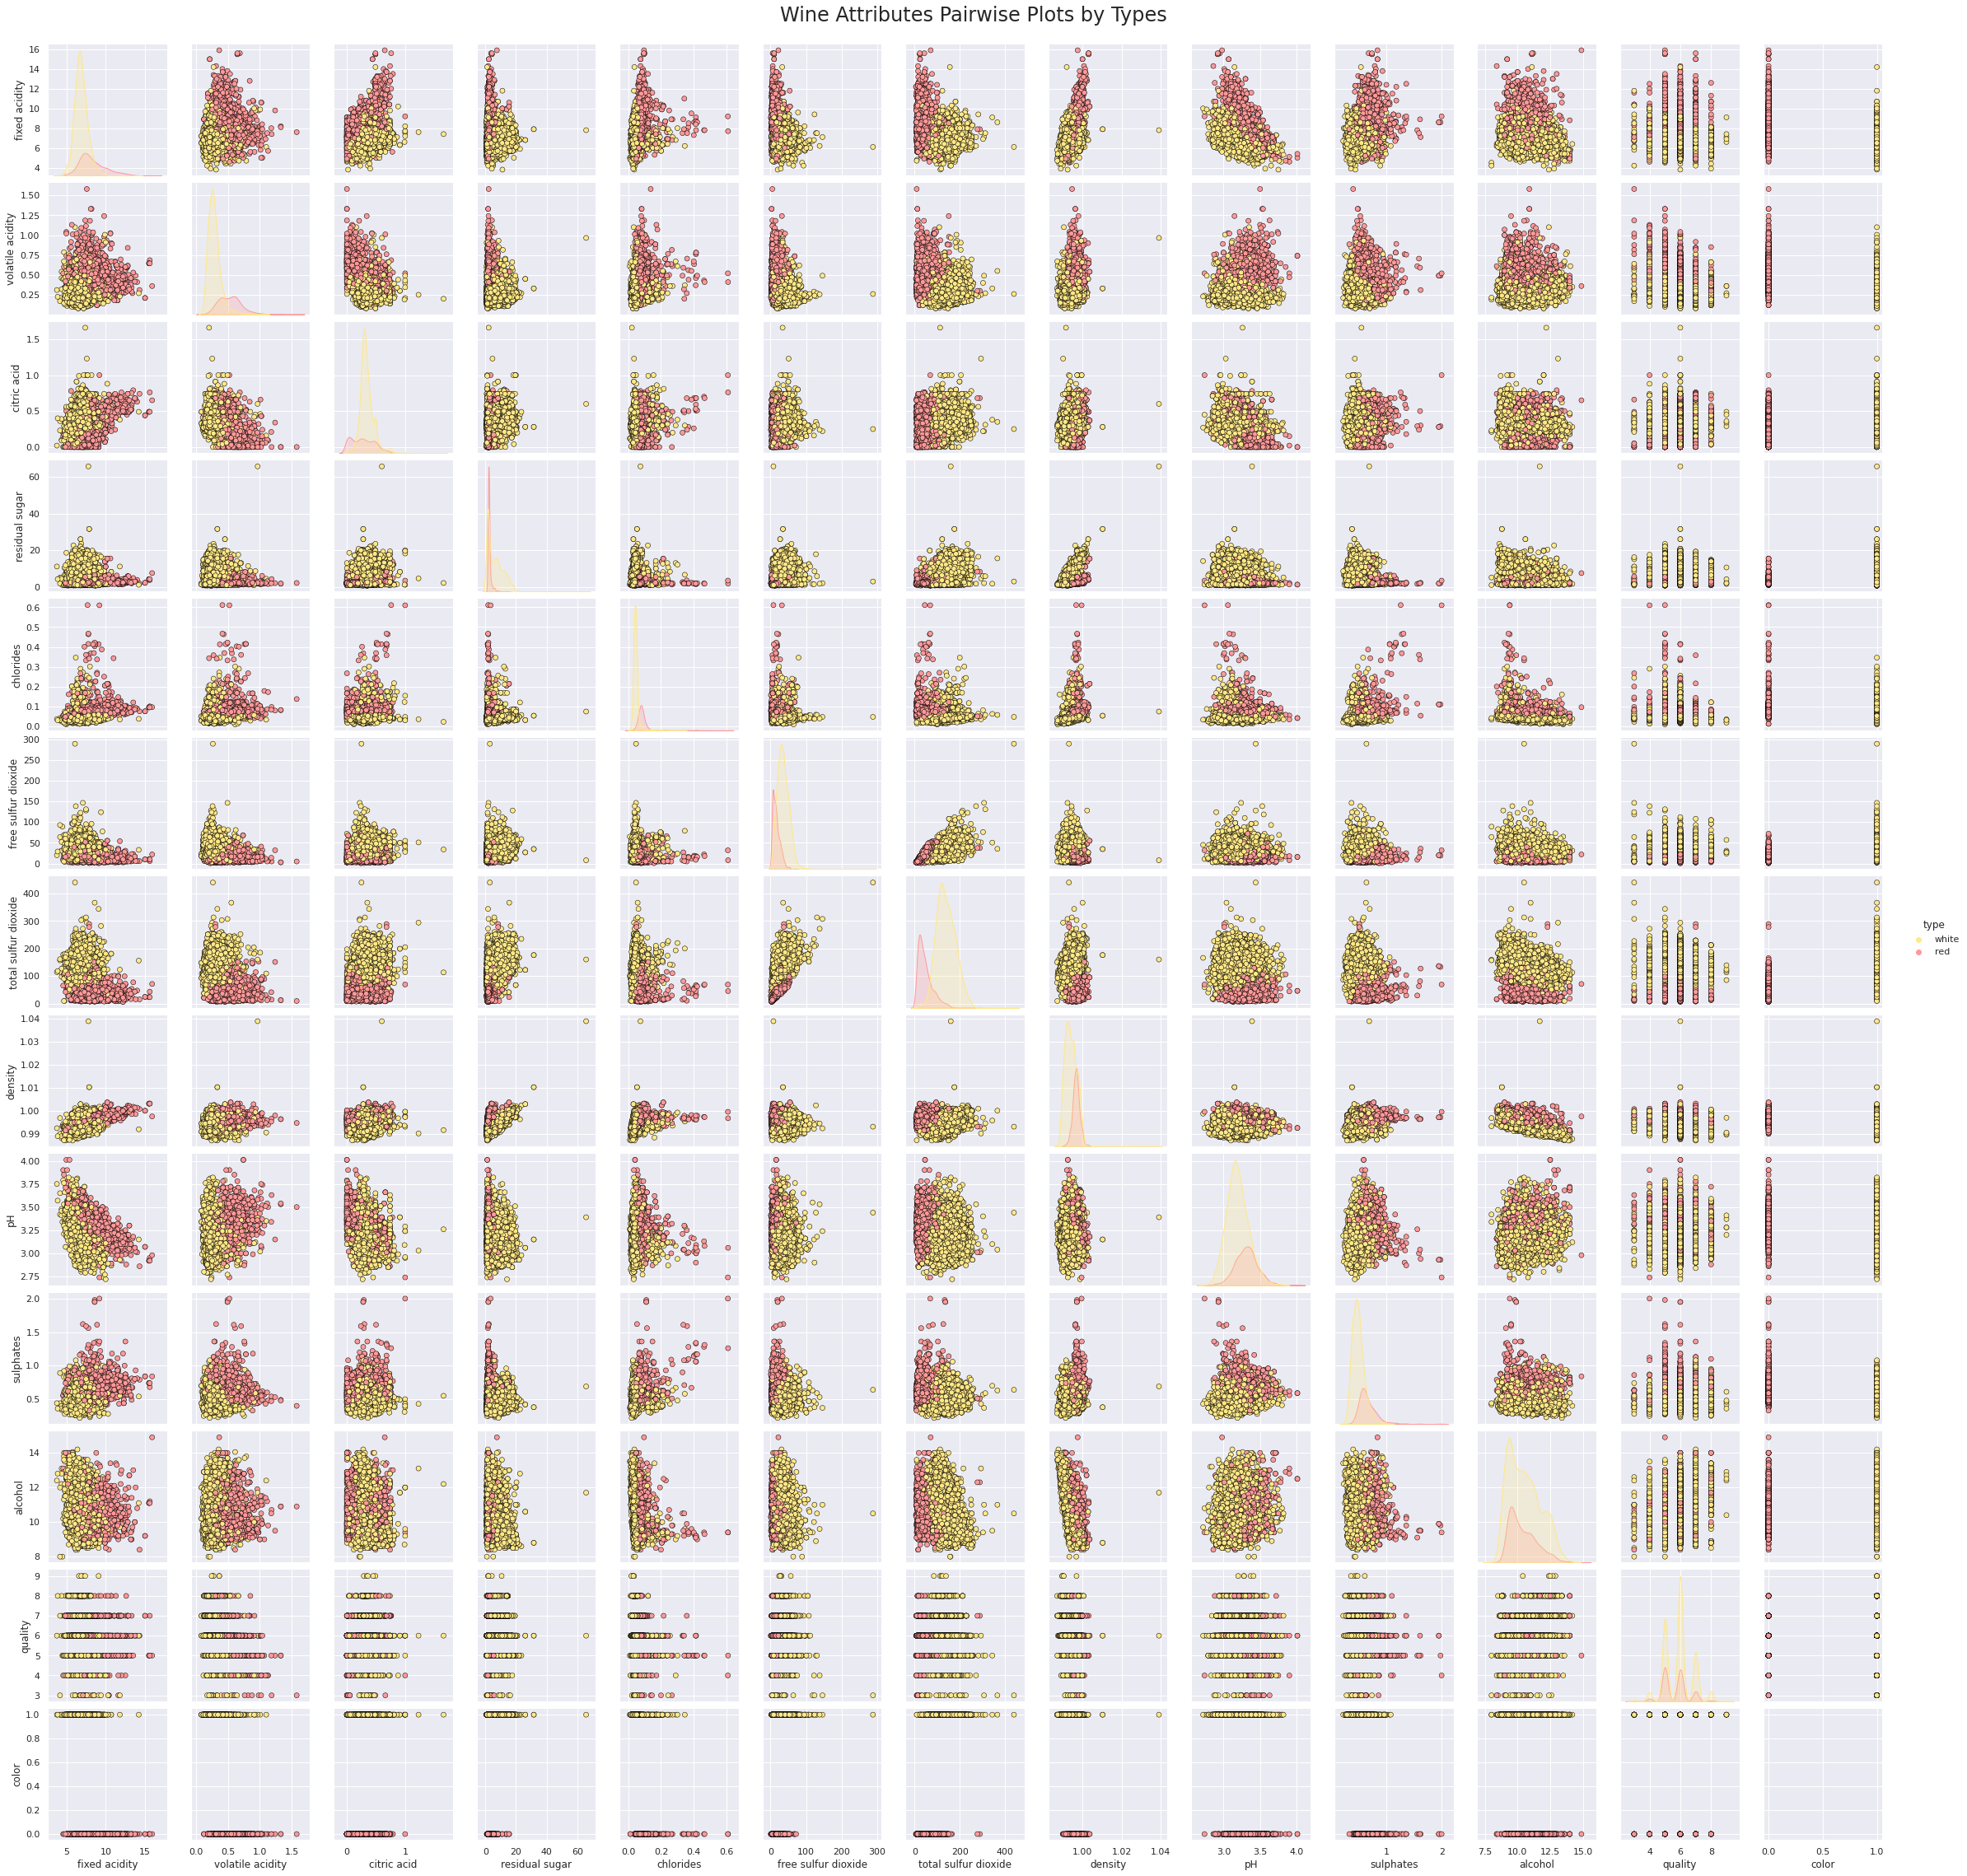

In [138]:


sns.set(font_scale=1.0)
g = sns.pairplot(data = wines, hue='type', palette={'red': '#FF9999', 'white': '#FFE888'},plot_kws=dict(edgecolor='black', linewidth=0.5))
fig = g.fig 
fig.subplots_adjust(top=0.96, wspace=0.2)
t = fig.suptitle('Wine Attributes Pairwise Plots by Types', fontsize=24)



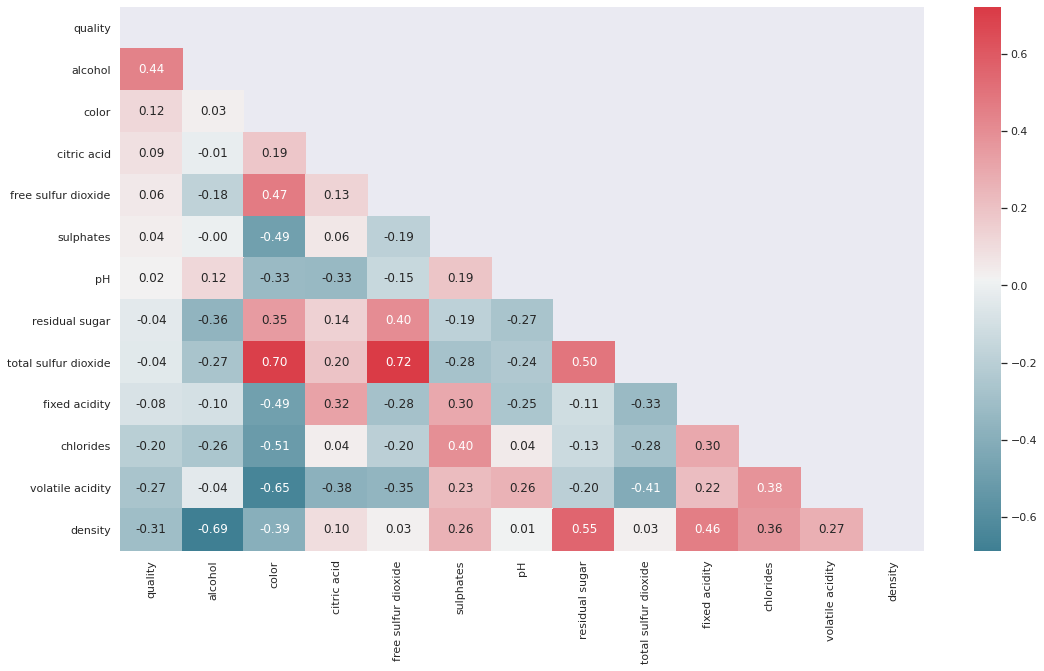

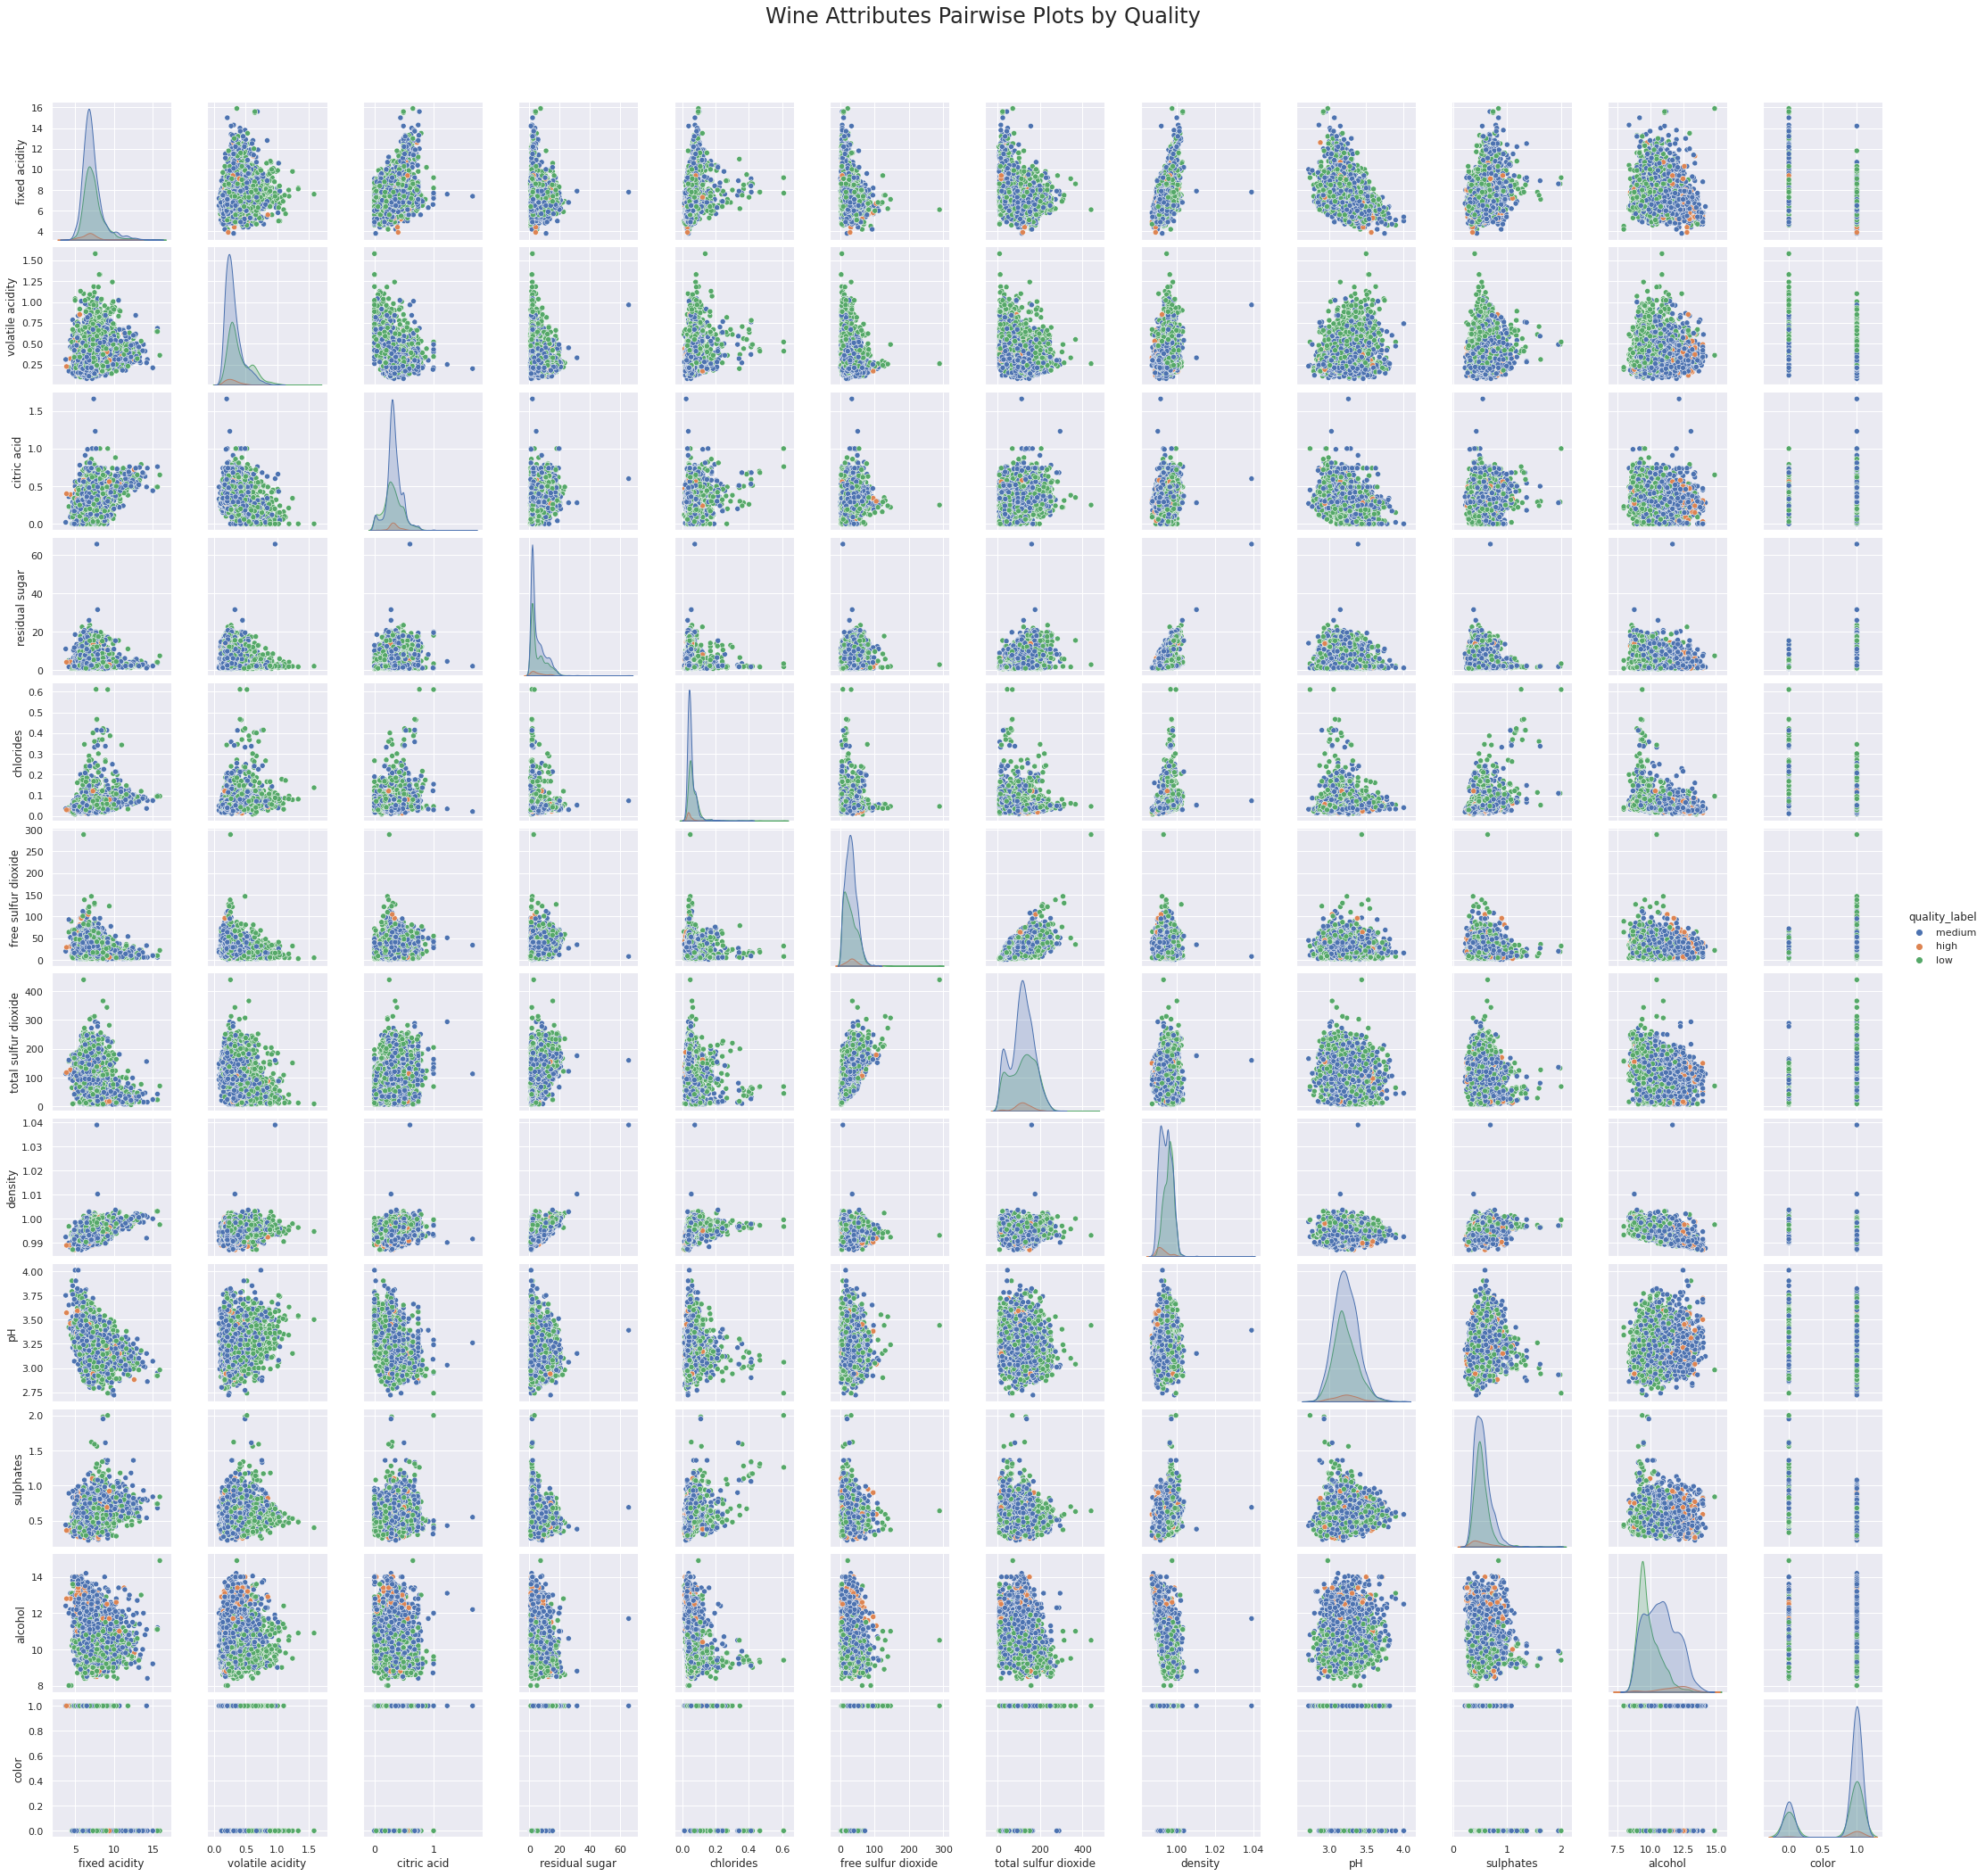

In [139]:
corr = wines.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t

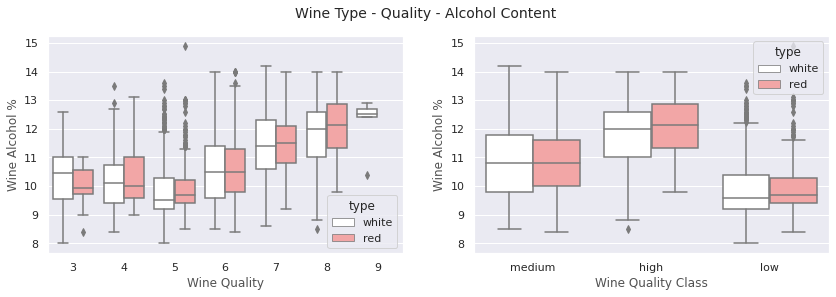

In [140]:


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Alcohol Content', fontsize=14)

sns.boxplot(x='quality', y='alcohol', hue='type', data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)

sns.boxplot(x='quality_label', y='alcohol', hue='type', data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)
plt.show()



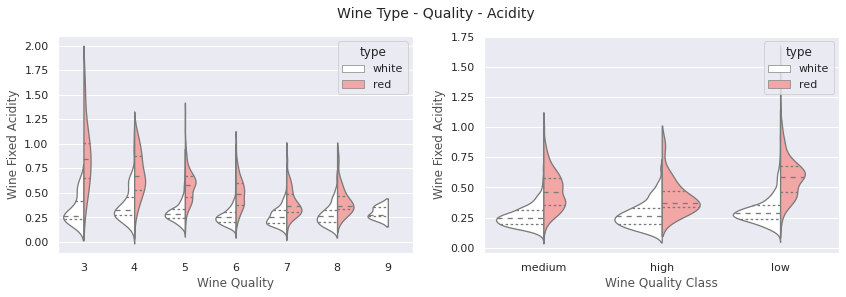

In [141]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Acidity', fontsize=14)

sns.violinplot(x='quality', y='volatile acidity', hue='type', data=wines, split=True, inner='quart', linewidth=1.3,
               palette={'red': '#FF9999', 'white': 'white'}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)

sns.violinplot(x='quality_label', y='volatile acidity', hue='type', data=wines, split=True, inner='quart', linewidth=1.3,
               palette={'red': '#FF9999', 'white': 'white'}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)
plt.show()

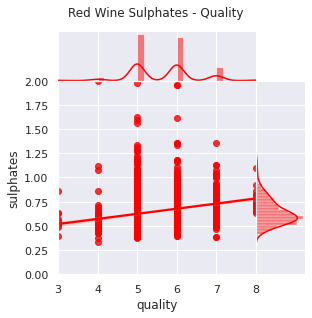

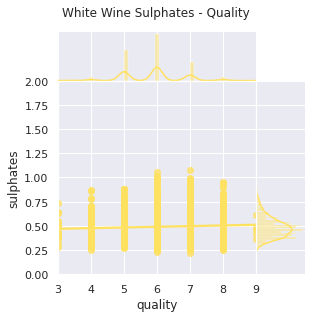

In [142]:
r = sns.jointplot(x='quality', y='sulphates', data=wines[wines.color == 0], # , ax = ax
                  kind='reg', ylim=(0, 2), color='red', space=0, size=4.5, ratio=4)
r.ax_joint.set_xticks(list(range(3,9)))
rfig = r.fig 
rfig.subplots_adjust(top=0.9)
t = rfig.suptitle('Red Wine Sulphates - Quality', fontsize=12)

w = sns.jointplot(x='quality', y='sulphates', data=wines[wines.color == 1],
                   kind='reg', ylim=(0, 2), color='#FFE160', space=0, size=4.5, ratio=4)
w.ax_joint.set_xticks(list(range(3,10)))
wfig = w.fig 
wfig.subplots_adjust(top=0.9)
t = wfig.suptitle('White Wine Sulphates - Quality', fontsize=12)

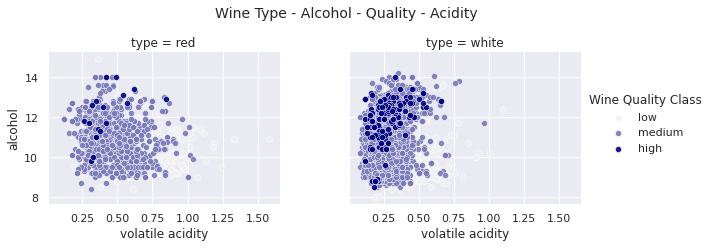

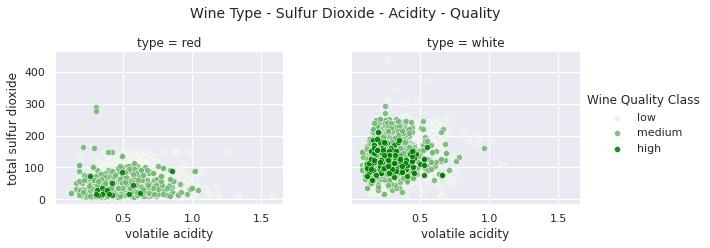

In [143]:


g = sns.FacetGrid(wines, col='type', hue='quality_label', col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, size=3.5, palette=sns.light_palette('navy', 3))
g.map(plt.scatter, 'volatile acidity', 'alcohol', alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Alcohol - Quality - Acidity', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

g = sns.FacetGrid(wines, col='type', hue='quality_label', col_order=['red', 'white'], hue_order=['low', 'medium', 'high'],
                  aspect=1.2, size=3.5, palette=sns.light_palette('green', 3))
g.map(plt.scatter, "volatile acidity", "total sulfur dioxide", alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Sulfur Dioxide - Acidity - Quality', fontsize=14)
l = g.add_legend(title='Wine Quality Class')



In [144]:
numeric_features = list(wines.dtypes[(wines.dtypes != "str") & (wines.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines[feat], l_opt[feat] = boxcox((wines[feat]+1))

skewed_features2 = wines[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 6 higest skewed numerical features to box cox transform


Skew  New Skew
chlorides            5.398581  0.188756
sulphates            1.796855  0.010097
fixed acidity        1.722892 -0.062778
volatile acidity     1.494751  0.113297
residual sugar       1.435073  0.136535
free sulfur dioxide  1.219784 -0.036864

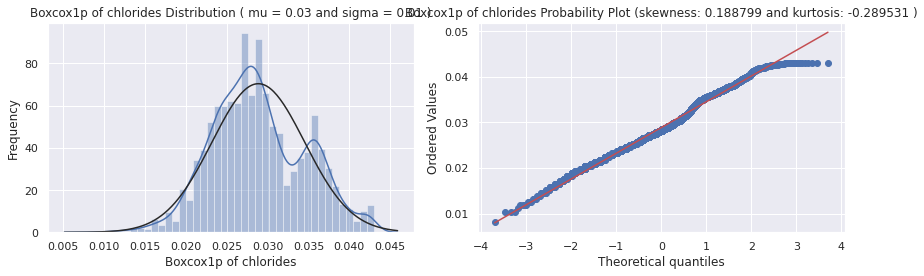

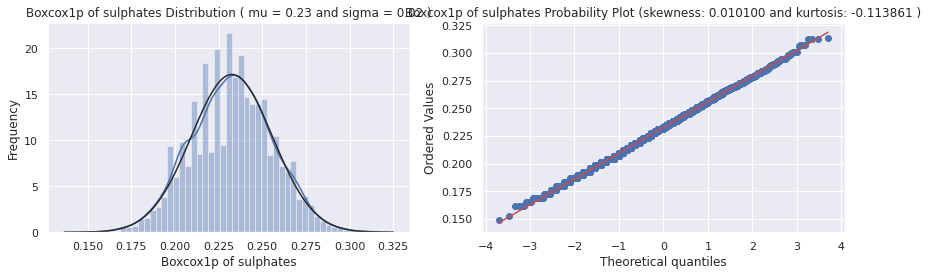

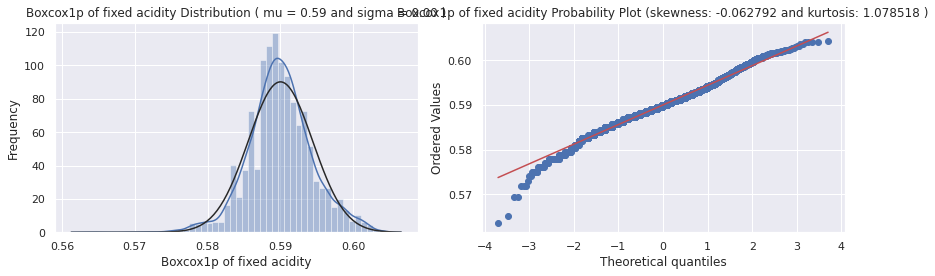

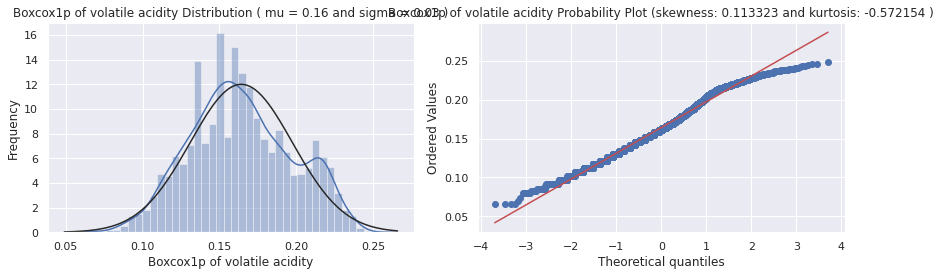

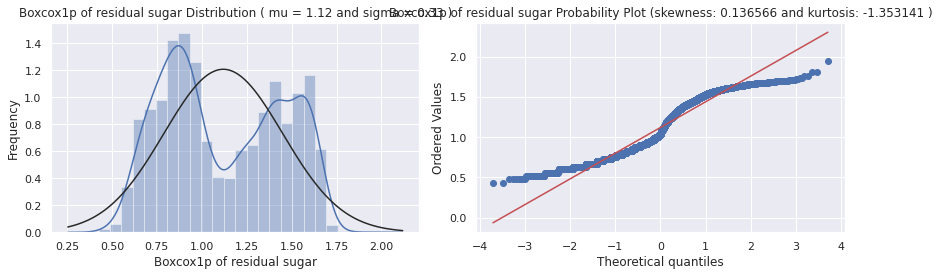

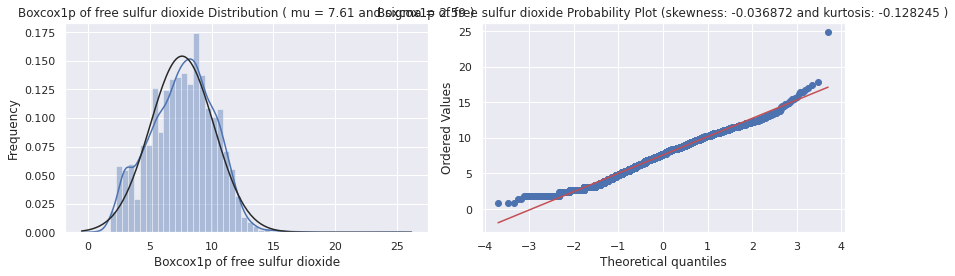

In [145]:


def QQ_plot(data, measure):
    fig = plt.figure(figsize=(12,4))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.\
                   format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()
    
for feat in skewness.index:
    QQ_plot(wines[feat], ('Boxcox1p of {}'.format(feat)))



In [146]:


from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)



VIF Factor              features
0     1.000000             Intercept
3     1.457790           citric_acid
10    1.459882             sulphates
2     1.911998      volatile_acidity
9     1.926934                    pH
6     2.490008   free_sulfur_dioxide
5     2.559318             chlorides
1     2.726905         fixed_acidity
11    3.660440               alcohol
4     3.820478        residual_sugar
7     4.276295  total_sulfur_dioxide
12    6.479333                 color
8     9.174436               density

In [147]:
cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000000            Intercept
8     1.402468            sulphates
3     1.435059          citric_acid
5     1.529382  free_sulfur_dioxide
7     1.661608                   pH
2     1.807560     volatile_acidity
1     2.254218        fixed_acidity
4     2.509295            chlorides
9     2.647479              alcohol
6     3.308427              density
10    4.062087                color

In [155]:
class select_fetaures(object): # BaseEstimator, TransformerMixin, 
    def __init__(self, select_cols):
        self.select_cols_ = select_cols
    
    def fit(self, X, Y ):
        pass

    def transform(self, X):
        return X.loc[:, self.select_cols_]    

    def fit_transform(self, X, Y):
        self.fit(X, Y)
        df = self.transform(X)
        return df    

    def __getitem__(self, x):
        return self.X[x], self.Y[x]

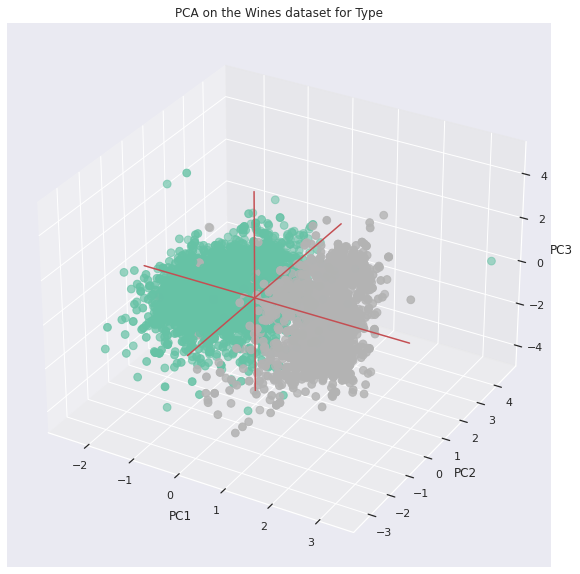

KNeighbors Classifier Training Accuracy: 100.00%
KNeighbors Classifier Test Accuracy: 99.54%
________________________________________

Accurance on Type  Prediction By Number of PCA COmponents:



Var_ratio  Train_Acc  Test_Acc
Components                                
4           70.679122        1.0  0.992821
7           87.703163        1.0  0.992821
6           82.979523        1.0  0.992308
5           77.692667        1.0  0.991795
8           91.826399        1.0  0.991282
10          97.665037        1.0  0.991282
11          99.428302        1.0  0.991282
9           95.146996        1.0  0.990769
2           48.458396        1.0  0.984615
3           61.515141        1.0  0.983590
1           26.097984        1.0  0.976410

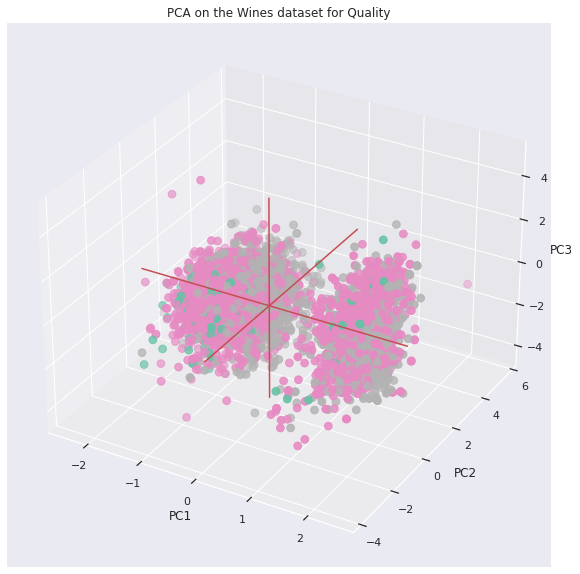

KNeighbors Classifier Training Accuracy: 100.00%
KNeighbors Classifier Test Accuracy: 78.46%
________________________________________

Accurance on Quality  Prediction By Number of PCA COmponents:



Var_ratio  Train_Acc  Test_Acc
Components                                
10          98.579398        1.0  0.791795
9           96.547000        1.0  0.786667
6           85.696041        1.0  0.785128
8           93.549557        1.0  0.784103
7           90.047421        1.0  0.781026
11          99.486115        1.0  0.781026
5           80.590726        1.0  0.767692
4           74.604039        1.0  0.764103
3           66.537544        1.0  0.730769
2           53.892279        1.0  0.724615
1           32.451800        1.0  0.665128

In [156]:
def pca_analysis(df, y_train, feat):
    scale = StandardScaler()
    df = pd.DataFrame(scale.fit_transform(df), index=df.index)
    pca_all = PCA(random_state=101, whiten=True).fit(df)

    my_color=y_train

    # Store results of PCA in a data frame
    result=pd.DataFrame(pca_all.transform(df), columns=['PCA%i' % i for i in range(df.shape[1])], index=df.index)

    # Plot initialisation
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap="Set2_r", s=60)

    # make simple, bare axis lines through space:
    xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA on the Wines dataset for " + (feat))
    plt.show()

    X_train , X_test, y, y_test = train_test_split(df , y_train, test_size=0.3, random_state=0)

    KNC = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size = 12, n_neighbors = 12, p  = 1, weights = 'distance')
    KNC = KNC.fit(X_train, y)
    print('KNeighbors Classifier Training Accuracy: {:2.2%}'.format(accuracy_score(y, KNC.predict(X_train))))
    y_pred = KNC.predict(X_test)
    print('KNeighbors Classifier Test Accuracy: {:2.2%}'.format(accuracy_score(y_test, y_pred)))

    print('_' * 40)
    print('\nAccurance on', feat, ' Prediction By Number of PCA COmponents:\n')
    AccPca = pd.DataFrame(columns=['Components', 'Var_ratio', 'Train_Acc', 'Test_Acc'])

    for componets in np.arange(1, df.shape[1]):
        variance_ratio = sum(pca_all.explained_variance_ratio_[:componets])*100
        pca = PCA(n_components=componets, random_state=101, whiten=True)
        X_train_pca = pca.fit_transform(X_train)
        Components = X_train_pca.shape[1]
        KNC = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size = 12, n_neighbors = 12, p  = 1, weights = 'distance')
        KNC = KNC.fit(X_train_pca, y)
        Training_Accuracy = accuracy_score(y, KNC.predict(X_train_pca))
        X_test_pca = pca.transform(X_test)
        y_pred = KNC.predict(X_test_pca)
        Test_Accuracy = accuracy_score(y_test, y_pred)
        AccPca = AccPca.append(pd.DataFrame([(Components, variance_ratio, Training_Accuracy, Test_Accuracy)],
                                            columns=['Components', 'Var_ratio', 'Train_Acc', 'Test_Acc']))#], axis=0)

    AccPca.set_index('Components', inplace=True)
    display(AccPca.sort_values(by='Test_Acc', ascending=False))

cols = wines.columns
cols = list(cols.drop(['type', 'quality_label', 'color']))
pca_analysis(wines.loc[:, cols], y_tp, 'Type')

cols = wines.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
pca_analysis(wines.loc[:, cols], y_ql, 'Quality')